# <center> Advanced Machine Learning - Assignment 1
## <center> Soham Pyne (MDS202148) <br><br>

In [31]:
import os
import warnings
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [32]:
# Download and Save MNIST 
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform = transforms.ToTensor())
len(mnist),len(mnist_test)

(60000, 10000)

#### The input size is $1568$ and output is $100$

In [34]:
input_size = 1568
output_size = 100

#### Train test data split($70-30$ split)

In [35]:
def train_test_split(data,split_train = 0.70):
    trainSize = int(len(data)*split_train)
    validationSize = len(data) - trainSize
    
    trainData, valData = torch.utils.data.random_split(data, [trainSize, validationSize])
    
    return trainData,valData

mnist_train , mnist_validation = train_test_split(mnist,0.70)

len(mnist_train), len(mnist_validation) # Number of Images in each set

(42000, 18000)

#### Dataloader function which unloads $10$ datapoint at a time

In [36]:
train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = 10, shuffle = False)
validation_loader = torch.utils.data.DataLoader(mnist_validation , batch_size = 10, shuffle = False)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = 10 , shuffle = False)

len(train_loader),len(validation_loader),len(test_loader)

(4200, 1800, 1000)

#### The deep neural network containing three hidden layer containing $300,200,150$ nodes.

In [37]:
class DNN1(nn.Module):  
    def __init__(self):
        super(DNN1, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(nn.Linear(input_size,300),
                                     nn.ReLU(),
                                     nn.Linear(300,200),
                                     nn.ReLU(),
                                     nn.Linear(200,150),
                                     nn.ReLU(),
                                     nn.Linear(150,output_size),
                                     nn.LogSoftmax(dim=1)
                                     )
        
    def forward(self,x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
model = DNN1()

#### Function to generate double mnist dataset

In [39]:
def DatasetGen(tuple_data):
    images,labels = tuple_data
    new_images = torch.empty((images.size(0)*images.size(0), images.size(1), images.size(2), images.size(3)*2))
    new_labels = torch.empty(labels.size(0)*images.size(0))
    for i in range(images.size(0)):
        for j in range(images.size(0)):
            img = torch.cat((images[i],images[j]), dim=2)
            lab = labels[i]*10 + labels[j]
            new_images[i*10 + j] = img
            new_labels[i*10 + j] = lab

    return new_images.to(torch.float), new_labels.to(torch.long)

In [43]:
epoch_no = 15

def train_model(train_loader,validation_loader,model):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    
    for epochs in range(1,epoch_no+1):
        total_n_train = 0 
        total_n_val = 0
        training_loss = 0
        validation_loss = 0
        training_accuracy = 0
        validation_accuracy = 0
        for i,data in enumerate(train_loader):
            model.train()
            inputs,targets = DatasetGen(data)
            flattened_input = torch.flatten(inputs, start_dim = 1)

            optimizer.zero_grad()
            output = model(flattened_input)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output,targets)
            loss.backward()
            optimizer.step()
            
            total_n_train += output.size(0)
            training_loss += loss.item() * inputs.size(0)
            training_accuracy += torch.sum(preds == targets.data)
            
        train_loss.append(training_loss/total_n_train)
        train_accuracy.append(training_accuracy/total_n_train)
        
        for i,data in enumerate(test_loader):
            model.eval()
            validation_double_mnist = DatasetGen(data)
            inputs,targets = validation_double_mnist
            
            flattened_input = torch.flatten(inputs, start_dim = 1)
            
            optimizer.zero_grad()
            output = model(flattened_input)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output,targets)
            
            loss.backward()
            optimizer.step()
            
            total_n_val += inputs.size(0)
            validation_loss += loss.item() * inputs.size(0)
            validation_accuracy += torch.sum(preds == targets.data)
        
        val_loss.append(validation_loss/total_n_val)
        val_accuracy.append(validation_accuracy/total_n_val)

    return train_loss,val_loss,train_accuracy,val_accuracy,inputs,targets,preds
    

In [44]:
train_loss,val_loss , train_accuracy,val_accuracy,inp,tar,pre = train_model(train_loader,validation_loader, model)

In [45]:
print("train accuracy is {:.4f}, valid accuracy is {:.4f}".format(train_accuracy[-1].item(),val_accuracy[-1].item()))

train accuracy is 0.9926, valid accuracy is 0.9942


In [57]:
# train_accuracy

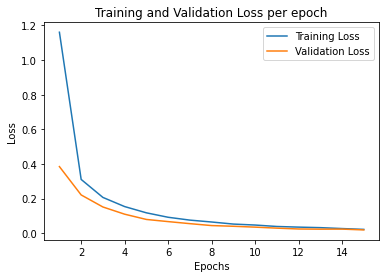

In [47]:
epochs = [i for i in range(1,epoch_no+1)]
plt.plot(epochs,train_loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [48]:
def test_nn(test_loader,model):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = []
    test_accuracy = []
    testing_loss = 0
    testing_accuracy = 0 
    total_n = 0
    for i, data in enumerate(test_loader):
        inputs,targets = DatasetGen(data)
        model.eval()
        #inputs = inputs.squeeze()
        
        flattened_input = torch.flatten(inputs, start_dim=1)

        output = model(flattened_input)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output,targets)
        
        total_n += flattened_input.size(0)
        testing_loss += loss.item() * flattened_input.size(0)
        testing_accuracy += torch.sum(preds == targets.data)

    test_loss.append(testing_loss/total_n)
    test_accuracy.append(testing_accuracy/total_n)
    
    return test_loss, test_accuracy ,total_n

In [49]:
test_loss,test_accuracy,total_n = test_nn(test_loader,model)
print("The test accuracy is given by {:.4f}".format(test_accuracy[-1].item()))
# print(total_n)

The test accuracy is given by 0.9898


In [50]:
test_accuracy

[tensor(0.9898)]

In [ ]:
# def cr_two_dg_images(images, labels):
#     new_images = torch.empty((images.size(0)*images.size(0), images.size(1), images.size(2), images.size(3)*2))
#     new_labels = torch.empty(labels.size(0)*images.size(0))
#     for i in range(images.size(0)):
#         for j in range(images.size(0)):
#             img = torch.cat((images[i],images[j]), dim=2)
#             lab = labels[i]*10 + labels[j]
#             new_images[i*10 + j] = img
#             new_labels[i*10 + j] = lab

#     return new_images, new_labels.to(int)

In [ ]:
# def DatasetGen(tuple_data):
#     double_img = []
#     double_lab = []
#     for j in range(len(tuple_data[1])):
#         for k in range(len(tuple_data[1])):
#             img_new = torch.cat((tuple_data[0][j],tuple_data[0][k]),dim = 2)
#             label_new = int(10*tuple_data[1][j].item()+tuple_data[1][k].item())
#             double_img.append(img_new.flatten())
#             double_lab.append(label_new)
#     return double_img,double_lab

In [ ]:
# #counter = 0
# for i,(input,output) in enumerate(train_loader):
#     data = DatasetGen((input,output))
    
# len(data)

In [ ]:
# f = np.random.randint(59000 , size = 20)
# for k in f:
#     #print(k)
#     plt.imshow(data[k][0].squeeze())
#     plt.show()
#     print(data[k][1])